In [60]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import datetime as dt

In [61]:
import sunradiation as sun
import weatherfeed as wf
import emoncmsfeed as getfeeds

# Téléchargement des données et premier traitement

In [84]:
coords_grenoble = (45.1973288, 5.7139923)

startday = pd.to_datetime('22/06/2017', format='%d/%m/%Y').tz_localize('Europe/Paris')
lastday = pd.to_datetime('now').tz_localize('Europe/Paris')

## Météo
https://darksky.net

In [63]:
# download the data:
weatherdata = wf.buildmultidayDF(startday, lastday, coords_grenoble )

22, 23, 24, 25, 26, 27, 28, 29, 30, 1, 2, 3, 4, 5, 6, 7, 8, done


In [64]:
weatherdata = weatherdata.resample('15min').interpolate('linear')

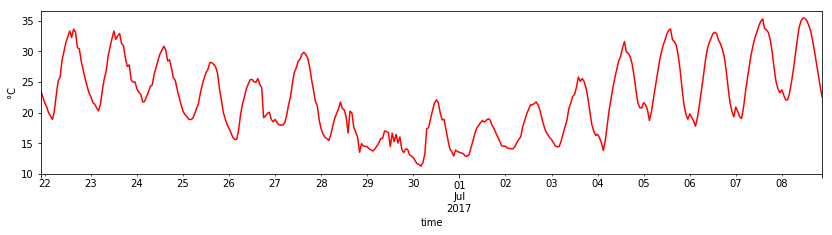

In [65]:
weatherdata['temperature'].plot(figsize=(14, 3), color='r' );  plt.ylabel('°C');

## Irradiation solaire

* Flux sur une surface perpendiculaire
* Sans la radiation diffuse (?)
* Prend en compte la couverture nuageuse (facteur multiplicatif)

In [66]:
sundata = sun.buildmultidayDF( coords_grenoble, weatherdata.index, cloudCover = weatherdata['cloudCover']  )

/home/etienne/Projets/thermique_appart/py3/lib/python3.5/site-packages/pysolar/time.py:105: UserWarning: I don't know about leap seconds after 2015
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


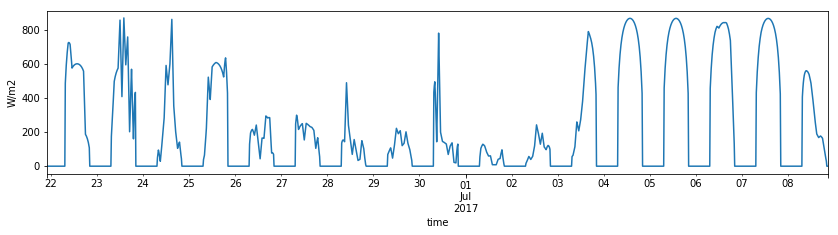

In [67]:
sundata['I0'].plot(figsize=(14, 3));  plt.ylabel('W/m2');

### Projection sur les surfaces vitrées

In [94]:
# surface m2,  sigma deg,  azimuth deg
windows = { 'bastille':(1.2*0.8,    37, 50) ,
            'cuisine':(0.3*0.72 *2, 90, 50 ),
            'chambre':(0.3*0.72 *2, 90, 180+50),
            'vercors':(0.6*0.8 * 2, 37, 180+50)
          }

In [95]:

sigma = 37  # deg, angle du toit
phi_C = 50  # deg, azimuth de la surface, zéro au sud, positif coté est

In [96]:
sunFlux_dict = {}

for k, values in windows.items():
    sunFlux_dict['flux_'+k] = values[0] * sun.projectDF( values[1], values[2], sundata )

flux_tot = pd.DataFrame( sunFlux_dict )

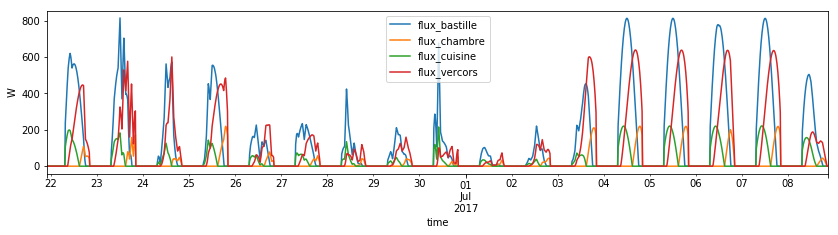

In [104]:
sunFlux.plot(figsize=(14, 3)); plt.ylabel('W');

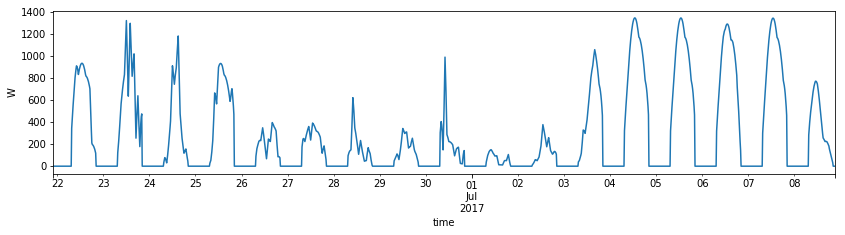

In [106]:
# Somme
flux_tot = sunFlux.sum(axis=1)

flux_tot.plot( figsize=(14, 3) ); plt.ylabel('W');

Rq: C'est le flux 'brut' reçu par les surfaces. Il faut ensuite prendre en compte la réflexion, la ré-émission ... etc

Au minimum: Facteur_g = 0.76 # Facteur solaire (prend en compte l'absorption et la ré-émission)

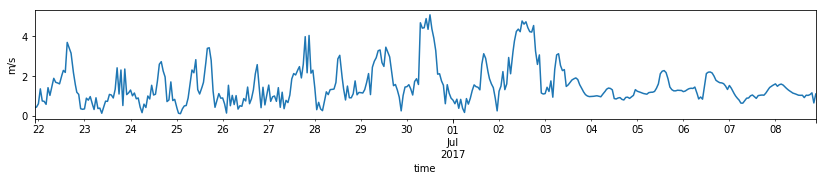

In [111]:
# Vitesse du vent
weatherdata['windSpeed'].plot(figsize=(14, 2));  plt.ylabel('m/s');

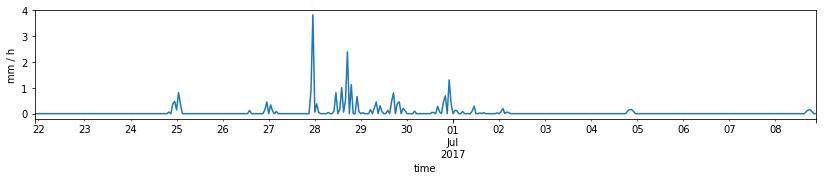

In [112]:
# Pluie
weatherdata['precipIntensity'].plot(figsize=(14, 2)); plt.ylabel('mm / h');

# Température intérieure mesurée

Téléchargement depuis EmonCMS

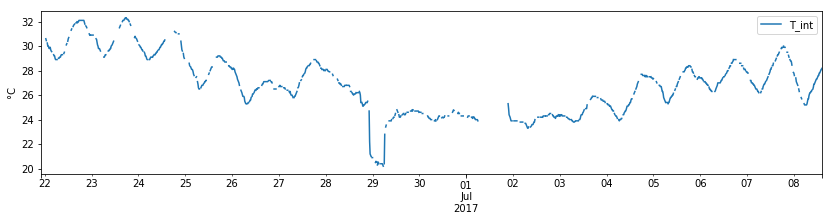

In [119]:
dataframefreq = '15min'
feeds =  { 'T_int': 3 }

Tmesure = getfeeds.builddataframe( feeds, dataframefreq , startdate=startday )
Tmesure.plot( figsize=(14, 3) ); plt.ylabel('°C');

In [120]:
# Remove some data 
mask_start = pd.to_datetime( '28/06/2017 22:00' ).tz_localize('Europe/Paris')
mask_end = pd.to_datetime( '29/06/2017 10:00' ) .tz_localize('Europe/Paris')

mask = (Tmesure.index > mask_start) & (Tmesure.index < mask_end )

Tmesure['T_int'].loc[mask] = np.nan

In [121]:
# Resample
Tmesure = Tmesure.resample('15min').mean()

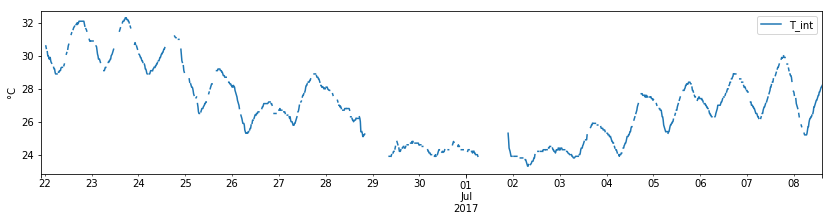

In [122]:
Tmesure.plot( figsize=(14, 3) ); plt.ylabel('°C');

In [81]:
# Merge
weatherdata['T_int'] = Tmesure['T_int'].interpolate()

# Save

In [82]:
weatherdata.to_pickle( 'weatherdata.pck' )

# Look

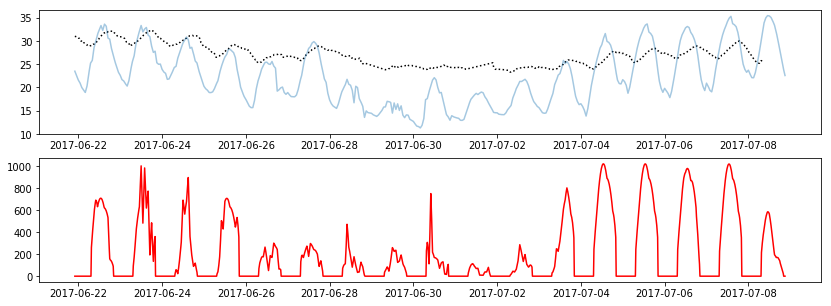

In [83]:
plt.figure( figsize=(14, 5) )
plt.subplot( 2, 1, 1 )
plt.plot(weatherdata['T_int'] , ':k')
plt.plot(weatherdata['temperature'], alpha=0.4);

plt.subplot( 2, 1, 2 )
plt.plot(weatherdata['flux_tot'] , 'r'); 
